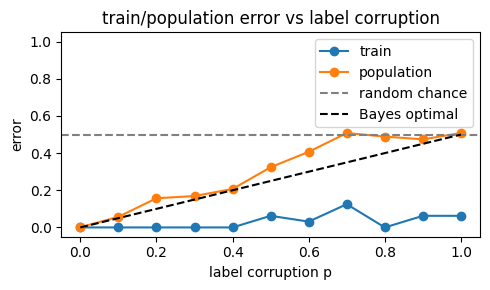

In [4]:
import numpy as np, torch
import torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(0)
rng_xtr = np.random.default_rng(4)
rng_xte = np.random.default_rng(5)     # different RNGs for train/test/corruption: so if we increase n_train or n_test, inputs and corrupted labels for first n_train/n_test points does not change (otw consumes more RNG calls)
rng_ytr = np.random.default_rng(6)
rng_yte = np.random.default_rng(7)

n_train, n_test = 32, 1000 # n_test large enough to sample [-1,1] with high resolution and get accurate test error estimate
width = 1024  # wide enough to interpolate at p=1 (n_train << width)
ps = np.linspace(0, 1.0, 11) # label corruption levels to sweep over

epochs=100_000
lr=1e-3

early_stop = True
nb_errors_allowed = 0               # early stop if <= this many errors
freq_check = 100                     # check early stop every freq_check epochs

train_err, test_err = [], []

for p in ps:
    # data = {(x, y)} with x~Unif([-1,1]), y = sign(x) with proba 1-p, y = Unif({0,1}) otw
    xtr = rng_xtr.uniform(-1, 1, (n_train, 1)).astype(np.float32)
    ytr = (xtr[:, 0] > 0).astype(np.float32)[:, None]

    xte = rng_xte.uniform(-1, 1, (n_test, 1)).astype(np.float32)
    yte = (xte[:, 0] > 0).astype(np.float32)[:, None]

    # corrupt train and test labels: pick exactly ceil(p * n_train) labels y to replace with Unif({0, 1})
    mask_ytr = rng_ytr.choice(n_train, size=int(np.ceil(p * n_train)), replace=False)
    mask_yte = rng_yte.choice(n_test, size=int(np.ceil(p * n_test)), replace=False)
    if mask_ytr.size > 0:
        ytr[mask_ytr] = rng_ytr.integers(0, 2, mask_ytr.size).astype(np.float32)[:, None]
    if mask_yte.size > 0:
        yte[mask_yte] = rng_yte.integers(0, 2, mask_yte.size).astype(np.float32)[:, None]

    xtr = torch.tensor(xtr)
    ytr = torch.tensor(ytr, dtype=torch.long).squeeze()
    xte = torch.tensor(xte)
    yte = torch.tensor(yte, dtype=torch.long).squeeze()


    net = nn.Sequential(nn.Linear(1, width), nn.ReLU(), nn.Linear(width, 2))
    opt = torch.optim.Adam(net.parameters(), lr=lr)

    # train until (almost) perfect fit
    for t in range(epochs):
        opt.zero_grad()
        logits = net(xtr)
        loss = F.cross_entropy(logits, ytr)
        loss.backward()
        opt.step()

        if early_stop and (t % freq_check == 0):
            with torch.no_grad():
                tr_err_now = (net(xtr).argmax(dim=1) != ytr).float().sum().item()
            if tr_err_now <= nb_errors_allowed:
                break

    with torch.no_grad():
        tr_err = (net(xtr).argmax(1) != ytr).float().mean().item()
        te_err = (net(xte).argmax(1) != yte).float().mean().item()

    train_err.append(tr_err); test_err.append(te_err)

plt.figure(figsize=(5,3))
plt.plot(ps, train_err, "o-", label="train")
plt.plot(ps, test_err, "o-", label="population")
plt.axhline(0.5, ls="--", color="gray", label="random chance")
plt.plot(ps, ps/2, "k--", label="Bayes optimal")  # Bayes error = p/2
plt.xlabel("label corruption p")
plt.ylabel("error")
plt.title("train/population error vs label corruption")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.tight_layout()
plt.show()